In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [25]:
stock_df = pd.read_csv("../dataset/Stock_Market_Preprocessed_Dataset.csv")

In [8]:
# Example DataFrame (ensure 'Date' is in datetime format)
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

# Convert 'Day' to ordinal (numeric representation)
stock_df['Day'] = pd.to_datetime(stock_df['Day']).map(lambda x: x.toordinal())

# Convert 'Month' to ordinal (numeric representation)
stock_df['Month'] = pd.to_datetime(stock_df['Month'], format='%Y-%m').map(lambda x: x.toordinal())

# Convert 'Date' to timestamps
stock_df['Date'] = stock_df['Date'].map(pd.Timestamp.timestamp)


In [9]:
stock_df[['Date', 'Day', 'Month']]

,Date,Day,Month
0,1.706832e+09,738918,738917
1,1.706746e+09,738917,738917
2,1.706659e+09,738916,738886
3,1.706573e+09,738915,738886
4,1.706486e+09,738914,738886
...,...,...,...
1238,1.549584e+09,737098,737091
1239,1.549498e+09,737097,737091
1240,1.549411e+09,737096,737091
1241,1.549325e+09,737095,737091


In [10]:
# Define target asset and features
target_asset = 'Bitcoin_Price'
features = stock_df.columns.drop(['Date', target_asset])

# Exclude the 'Date' column before scaling
numerical_data = stock_df.drop(columns=['Date'])

# Initialize the scaler and fit-transform on numerical data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(numerical_data)

# Convert scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=numerical_data.columns, index=stock_df.index)


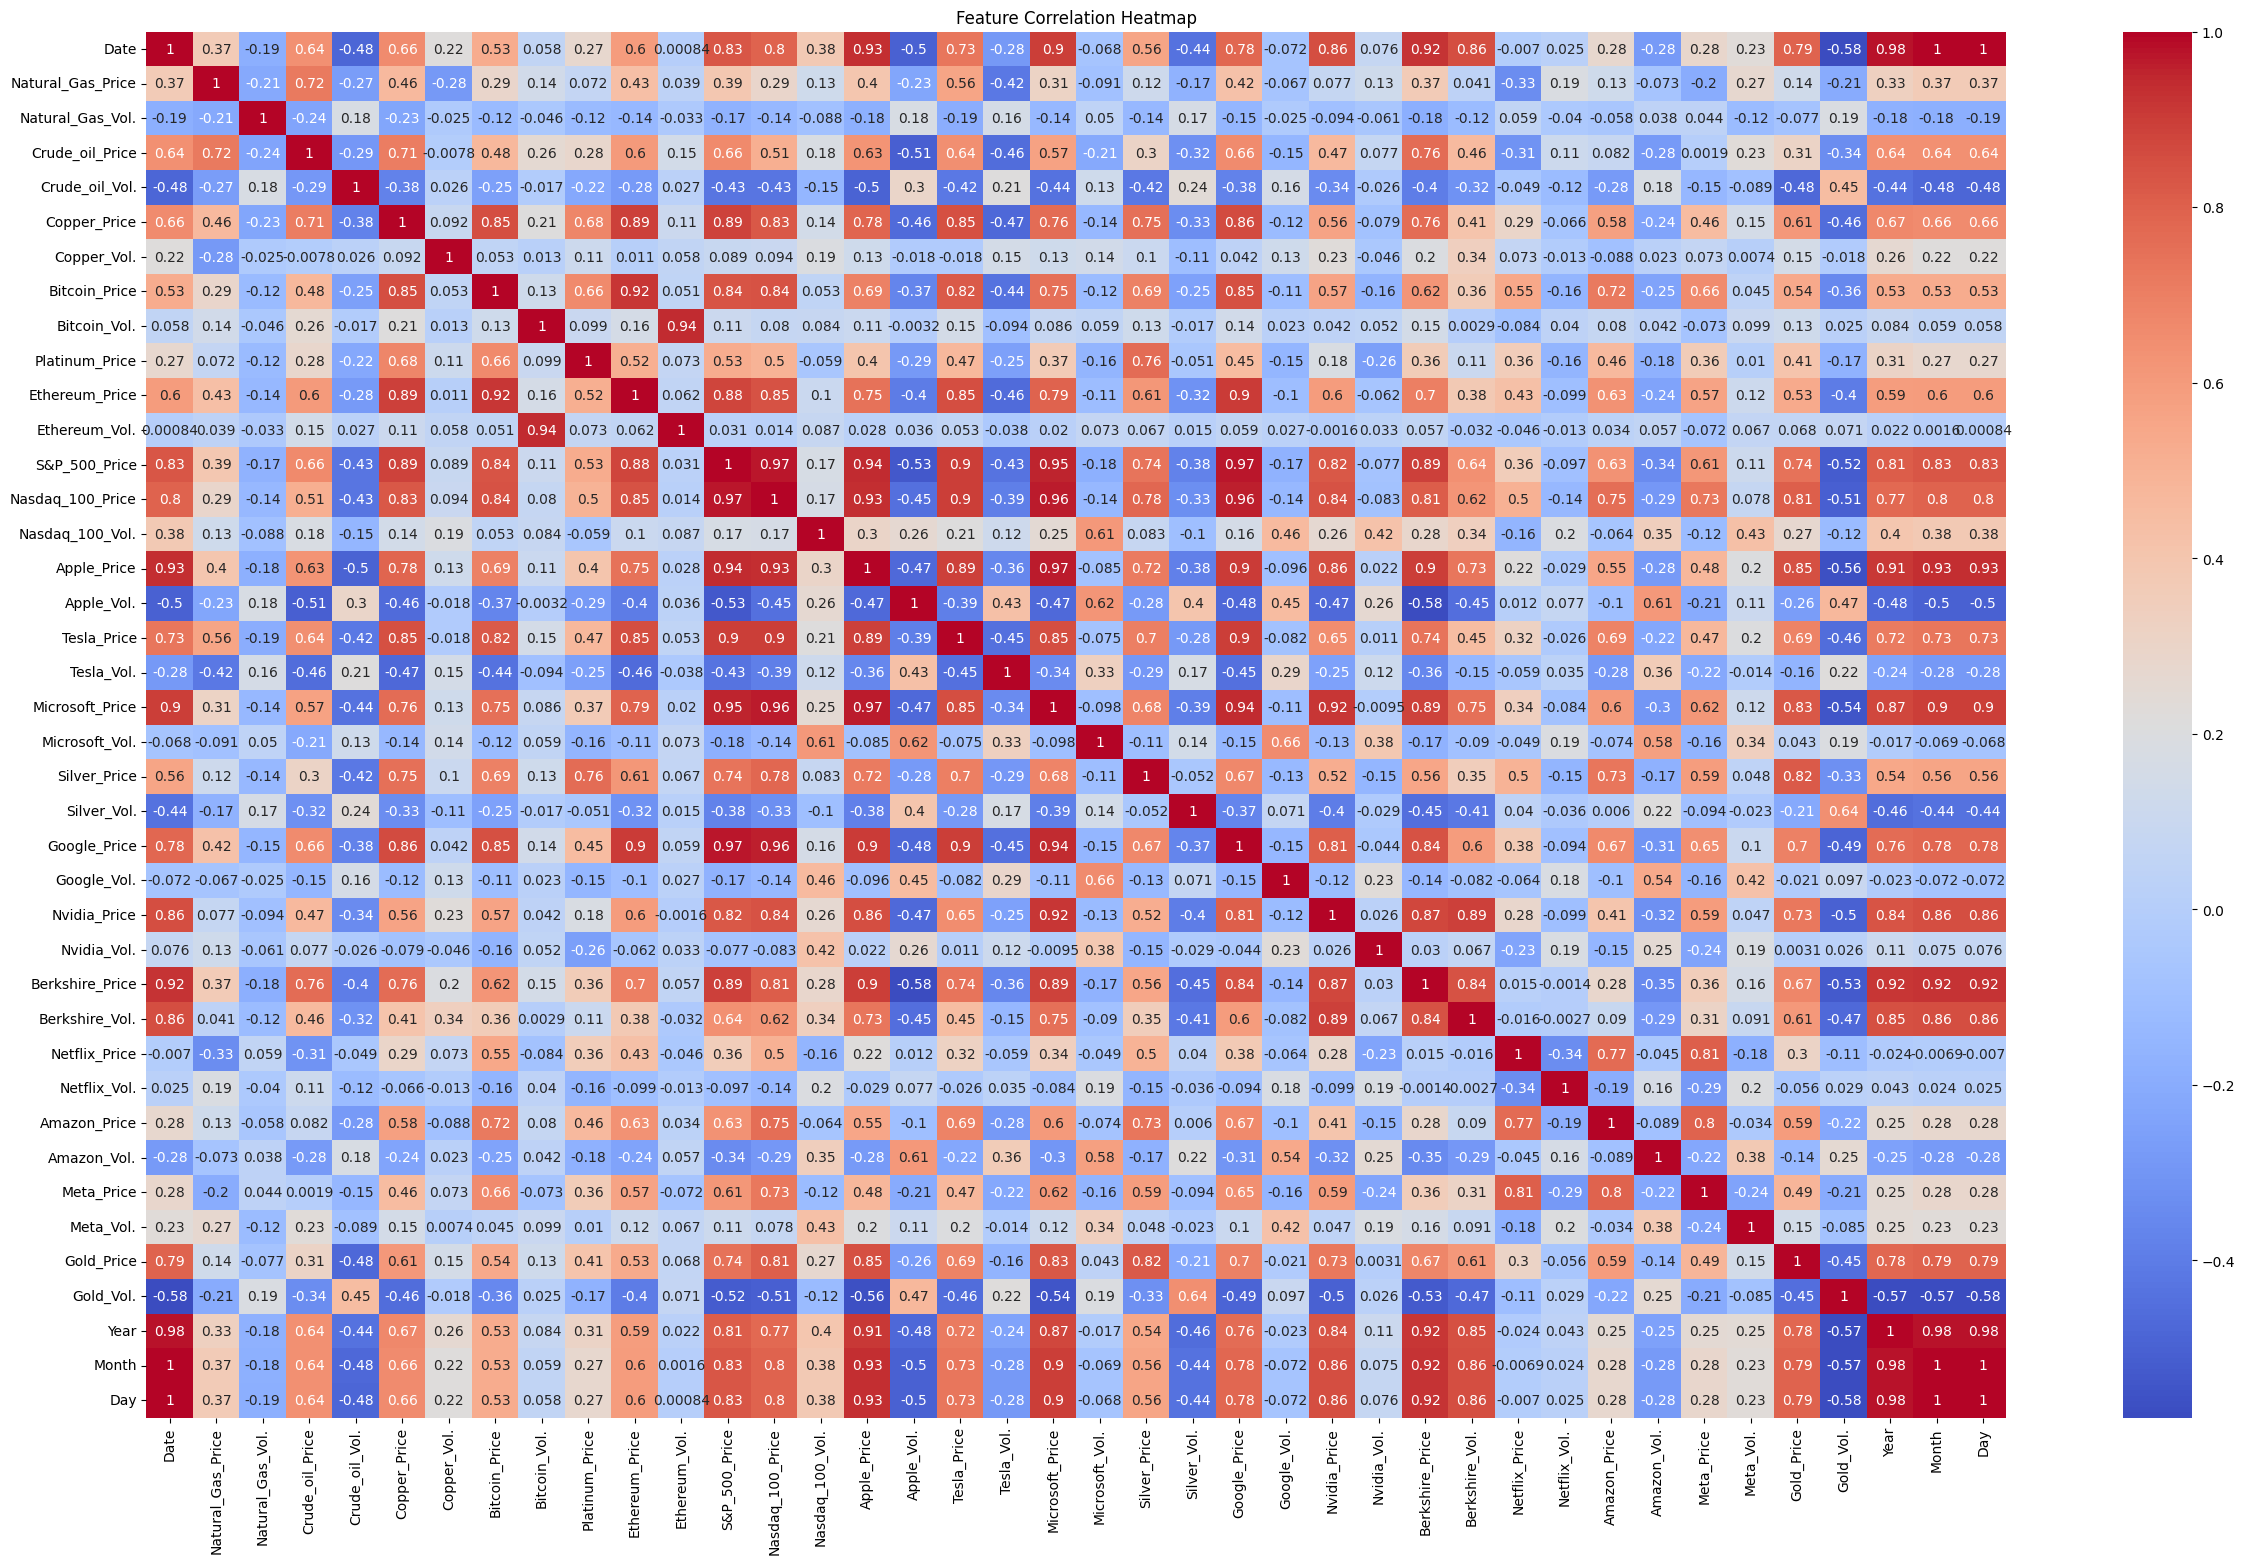

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
plt.figure(figsize=(30, 18))
sns.heatmap(stock_df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


In [14]:
train_size = int(len(scaled_df) * 0.8)
train_data = scaled_df[:train_size]
test_data = scaled_df[train_size:]

# Separate features and target
X_train = train_data.drop(columns=['Bitcoin_Price'])
y_train = train_data['Bitcoin_Price']
X_test = test_data.drop(columns=['Bitcoin_Price'])
y_test = test_data['Bitcoin_Price']


## ARIMA

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller


In [15]:
# Ensure Date is the index
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df.set_index('Date', inplace=True)

# Target Asset (e.g., Bitcoin_Price)
target_asset = 'Bitcoin_Price'
time_series = stock_df[target_asset]

In [18]:
# Perform ADF Test
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")

# Check stationarity of the target asset
adf_test(time_series)


ADF Statistic: -1.790161373173482
p-value: 0.38535712298583635
Series is not stationary


ADF Statistic: -6.09191685988041
p-value: 1.0315938535483229e-07
Series is stationary


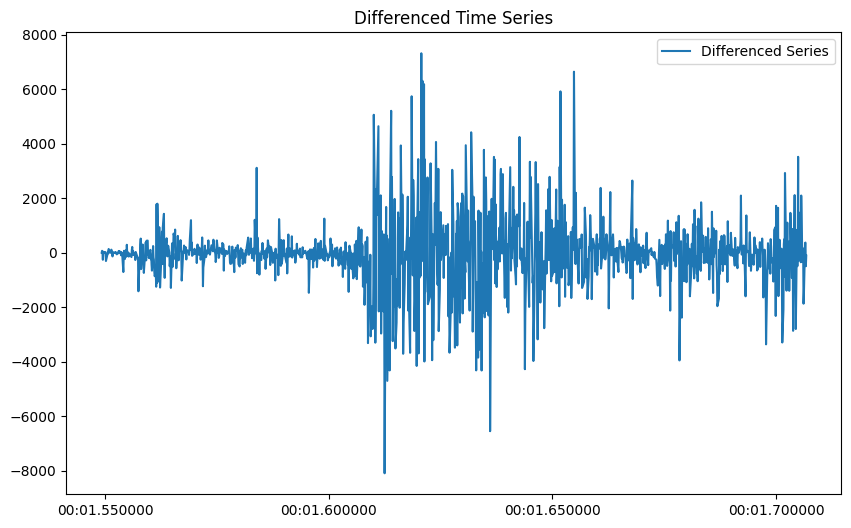

In [19]:
# Differencing to make the series stationary (if required)
diff_series = time_series.diff().dropna()

# Check stationarity of the differenced series
adf_test(diff_series)

# Plot the differenced series
plt.figure(figsize=(10, 6))
plt.plot(diff_series, label='Differenced Series')
plt.title("Differenced Time Series")
plt.legend()
plt.show()

In [20]:
# Fit ARIMA Model
model = ARIMA(time_series, order=(5, 1, 0))  # Adjust (p, d, q) as needed
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

c:\Users\kansa\OneDrive\Desktop\Stockie\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kansa\OneDrive\Desktop\Stockie\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kansa\OneDrive\Desktop\Stockie\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kansa\OneDrive\Desktop\Stockie\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when 

                               SARIMAX Results                                
Dep. Variable:          Bitcoin_Price   No. Observations:                 1243
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -10619.138
Date:                Sat, 07 Dec 2024   AIC                          21250.276
Time:                        10:26:52   BIC                          21281.022
Sample:                             0   HQIC                         21261.838
                               - 1243                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0092      0.023     -0.401      0.688      -0.054       0.036
ar.L2          0.0131      0.017      0.766      0.443      -0.020       0.047
ar.L3          0.0281      0.018      1.535      0.1

c:\Users\kansa\OneDrive\Desktop\Stockie\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kansa\OneDrive\Desktop\Stockie\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kansa\OneDrive\Desktop\Stockie\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kansa\OneDrive\Desktop\Stockie\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when 

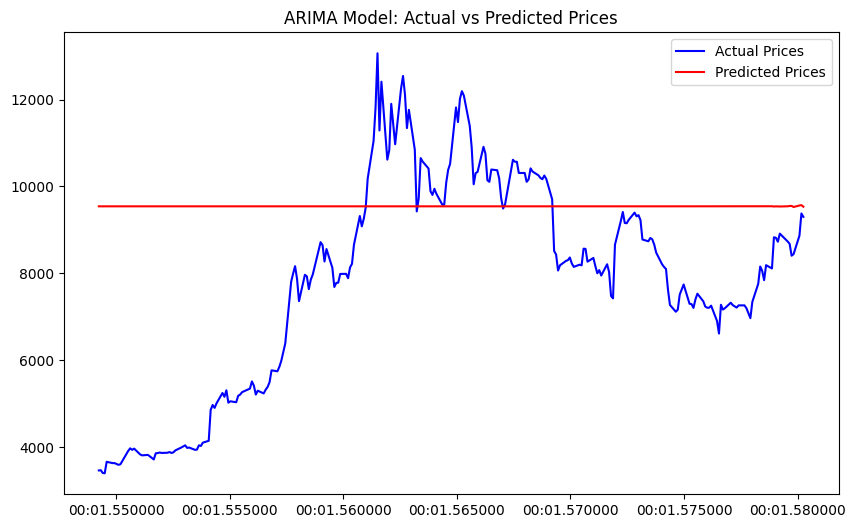

In [23]:
# Split data into train and test sets
train_size = int(len(time_series) * 0.8)
train, test = time_series[:train_size], time_series[train_size:]

# Fit ARIMA on train data
model = ARIMA(train, order=(10, 1, 0))  # Adjust (p, d, q) as needed
model_fit = model.fit()

# Forecast on test data
forecast = model_fit.forecast(steps=len(test))

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label="Actual Prices", color="blue")
plt.plot(test.index, forecast, label="Predicted Prices", color="red")
plt.title("ARIMA Model: Actual vs Predicted Prices")
plt.legend()
plt.show()

## LSTM

In [34]:
stock_df = pd.read_csv("../dataset/Stock_Market_Preprocessed_Dataset.csv")

In [35]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Load and preprocess data
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df.set_index('Date', inplace=True)

# Target Asset (e.g., Bitcoin_Price)
target_asset = 'Bitcoin_Price'
time_series = stock_df[target_asset].values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))

# Function to create sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create sequences
sequence_length = 120  # Use past 60 days to predict the next day
X, y = create_sequences(scaled_data, sequence_length)

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import GRU


# Build the LSTM model
# Improved LSTM Model
model = Sequential([
    GRU(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    GRU(100, return_sequences=False),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
])


model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

c:\Users\kansa\OneDrive\Desktop\Stockie\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [49]:
# Reshape X_train and X_test to match LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train the model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train with more epochs and early stopping
model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 0.1224 - val_loss: 0.0154
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0095 - val_loss: 0.0069
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0058 - val_loss: 0.0018
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0045 - val_loss: 3.7966e-04
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0037 - val_loss: 1.2989e-04
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0036 - val_loss: 1.1279e-04
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0042 - val_loss: 1.1450e-04
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0034 - val_loss: 1.2510e-04
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0042 - val_loss: 1.0548e-04
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0037 - val_loss: 1.8887e-04
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0031 - val_loss: 1.4741e-04
Epoch 12/50
57/57 ━━━━━━━━━━━━━

In [50]:
# Make predictions
predictions = model.predict(X_test)

# Inverse scale predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step


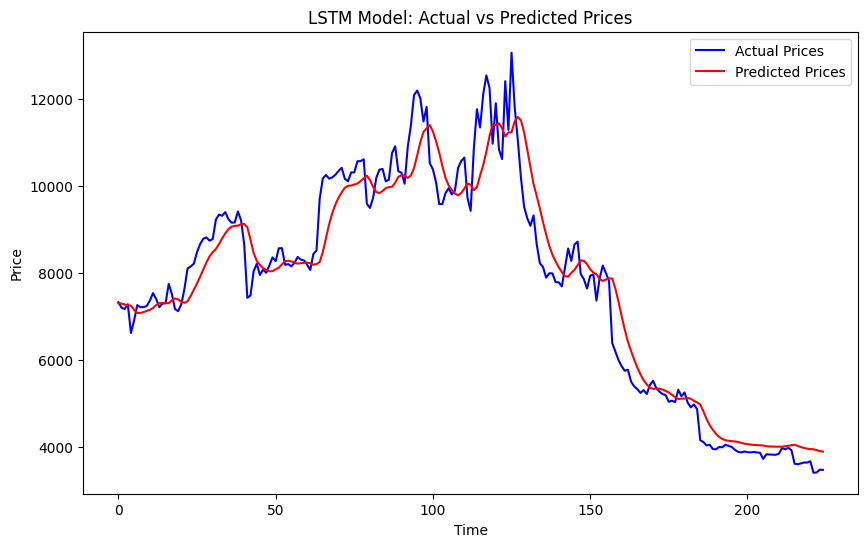

In [51]:
import matplotlib.pyplot as plt

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled, label="Actual Prices", color="blue")
plt.plot(predictions, label="Predicted Prices", color="red")
plt.title("LSTM Model: Actual vs Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate model performance
mse = mean_squared_error(y_test_scaled, predictions)
mae = mean_absolute_error(y_test_scaled, predictions)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")


Mean Squared Error (MSE): 410090.4510548549
Mean Absolute Error (MAE): 473.3667163628473


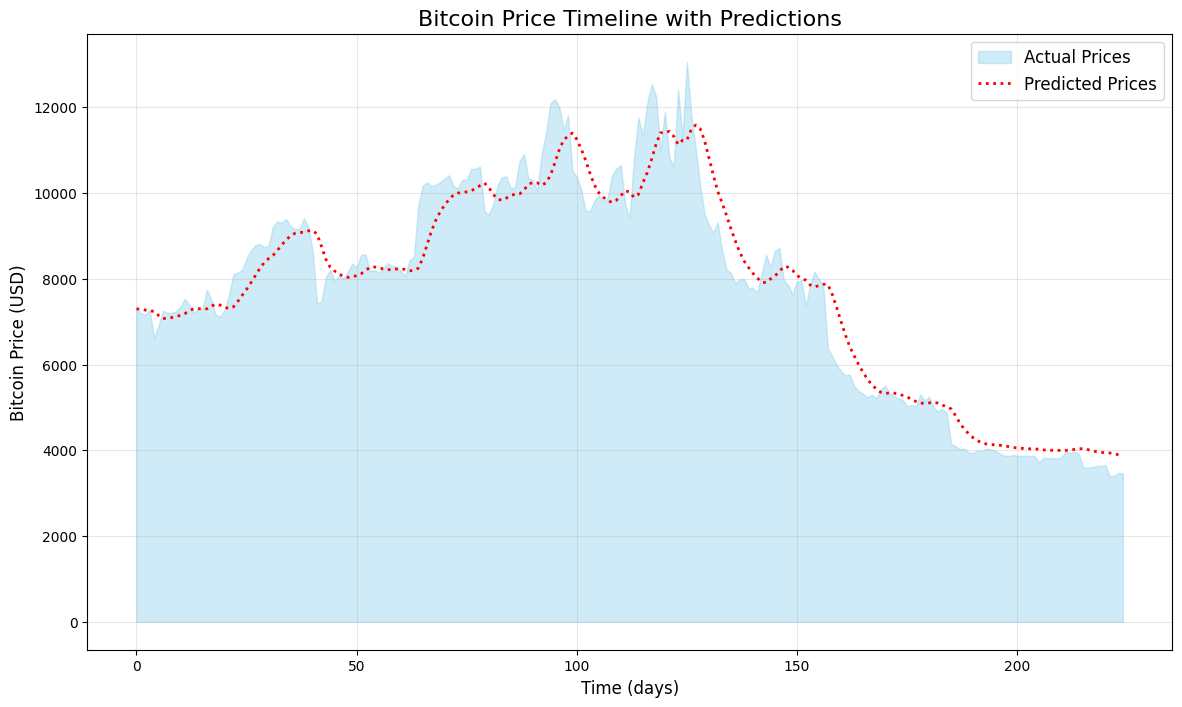

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Create a timeline for the test set
timeline = np.arange(len(y_test_scaled))  # Adjust for the length of y_test_scaled

# Plot the area chart for actual prices
plt.figure(figsize=(14, 8))
plt.fill_between(timeline, y_test_scaled.flatten(), color="skyblue", alpha=0.4, label="Actual Prices")

# Overlay the predicted prices as a dotted line
plt.plot(timeline, predictions.flatten(), linestyle='dotted', color="red", label="Predicted Prices", linewidth=2)

# Customize the chart
plt.title("Bitcoin Price Timeline with Predictions", fontsize=16)
plt.xlabel("Time (days)", fontsize=12)
plt.ylabel("Bitcoin Price (USD)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)  # Optional: light grid for better readability

# Show the plot
plt.show()

In [20]:
def predict_and_visualize(n_days, model, scaler, X_test, y_test, sequence_length):
    """
    Predict future prices for n_days and visualize the results.
    
    Parameters:
    - n_days (int): Number of future days to predict.
    - model (tf.keras.Model): Trained LSTM model.
    - scaler (MinMaxScaler): Scaler used for data preprocessing.
    - X_test (ndarray): Test dataset sequences.
    - y_test (ndarray): Actual test dataset values.
    - sequence_length (int): Sequence length used in the model.
    """
    # Initialize the last sequence from the test set
    last_sequence = X_test[-1]
    future_predictions = []

    for _ in range(n_days):
        # Reshape the sequence for prediction
        input_sequence = last_sequence.reshape((1, sequence_length, 1))
        predicted_price = model.predict(input_sequence)[0, 0]
        future_predictions.append(predicted_price)

        # Update the last sequence with the new prediction
        last_sequence = np.append(last_sequence[1:], predicted_price).reshape(-1, 1)
    
    # Inverse scale predictions and test data
    future_predictions_actual = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Extend predictions to include the last actual value
    extended_predictions = np.insert(future_predictions_actual.flatten(), 0, y_test_actual[-1])

    # Timelines
    test_timeline = np.arange(len(y_test))  # Test timeline
    future_timeline = np.arange(len(y_test) - 1, len(y_test) + n_days)  # Future timeline

    # Plot actual test prices as an area chart
    plt.figure(figsize=(14, 8))
    plt.fill_between(test_timeline, y_test_actual.flatten(), color="skyblue", alpha=0.4, label="Actual Test Prices")

    # Plot future predictions as a dotted line
    plt.plot(future_timeline, extended_predictions, linestyle='dotted', color="red", linewidth=2, label="Predicted Prices")

    # Add a gradient area for the predictions
    plt.fill_between(future_timeline, extended_predictions, color="lightcoral", alpha=0.3, label="Prediction Gradient")

    # Connect the last actual value to the first prediction
    plt.plot([test_timeline[-1], future_timeline[1]], 
             [y_test_actual[-1, 0], extended_predictions[1]], 
             linestyle="dashed", color="green", label="Connection Line")

    # Customize the plot
    plt.title(f"Bitcoin Price Prediction for {n_days} Days", fontsize=16)
    plt.xlabel("Time (days)", fontsize=12)
    plt.ylabel("Bitcoin Price (USD)", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


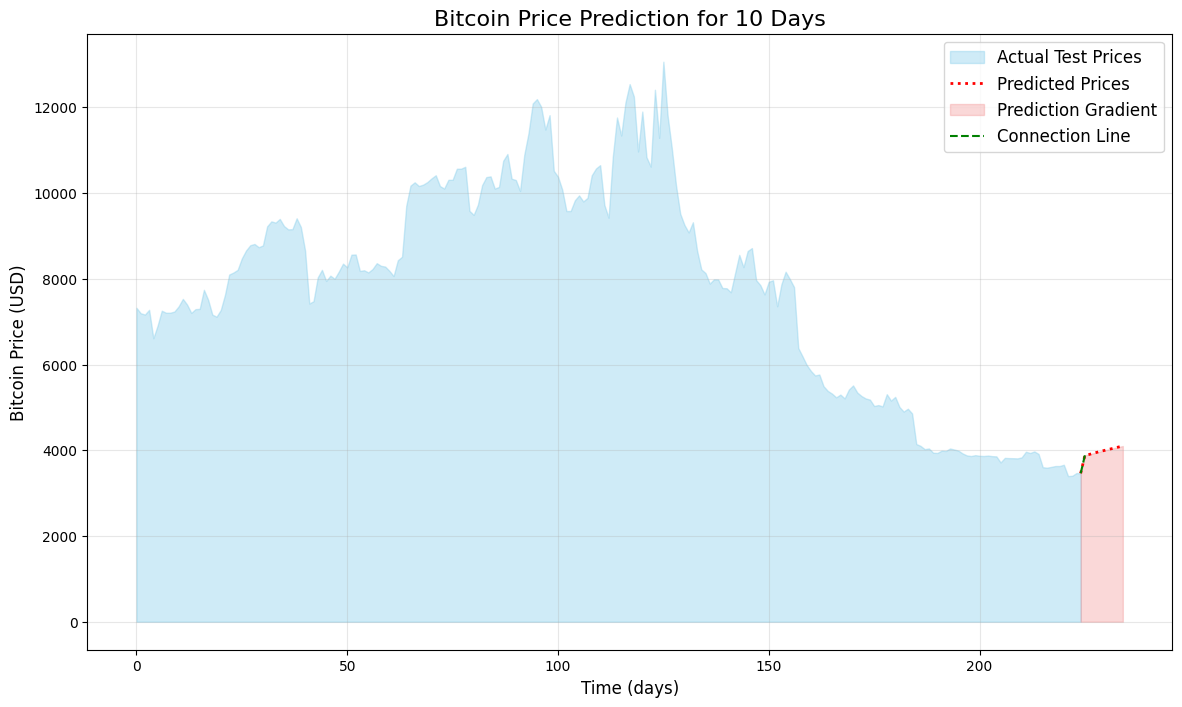

In [70]:
# Example usage:
n_days = 10  # Number of future days to predict
predict_and_visualize(n_days, model, scaler, X_test, y_test, sequence_length)


In [21]:
import pandas as pd

def save_predictions_to_csv(stock_name, n_days, model, scaler, X_test, y_test, sequence_length, output_file):
    """
    Save predictions along with actual data to a CSV file with labels to denote actual vs. predicted data.

    Parameters:
    - stock_name (str): The name of the stock (e.g., Bitcoin).
    - n_days (int): Number of days to predict into the future.
    - model (tf.keras.Model): The trained LSTM model.
    - scaler (MinMaxScaler): Scaler used for data preprocessing.
    - X_test (ndarray): Test sequences.
    - y_test (ndarray): Actual test target values.
    - sequence_length (int): Sequence length used in the model.
    - output_file (str): Path to save the CSV file.
    """
    # Initialize the last sequence from the test set
    last_sequence = X_test[-1]
    future_predictions = []

    for _ in range(n_days):
        # Reshape the sequence for prediction
        input_sequence = last_sequence.reshape((1, sequence_length, 1))
        predicted_price = model.predict(input_sequence)[0, 0]
        future_predictions.append(predicted_price)

        # Update the last sequence with the new prediction
        last_sequence = np.append(last_sequence[1:], predicted_price).reshape(-1, 1)
    
    # Inverse scale predictions and actual data
    future_predictions_actual = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Prepare data for saving
    # Actual data
    actual_data = pd.DataFrame({
        "Date": pd.date_range(start="2024-01-01", periods=len(y_test_actual)),  # Example date range
        "Price": y_test_actual.flatten(),
        "Data_Type": "actual",
        "Stock": stock_name
    })

    # Predicted data
    predicted_data = pd.DataFrame({
        "Date": pd.date_range(start=actual_data["Date"].iloc[-1] + pd.Timedelta(days=1), periods=n_days),
        "Price": future_predictions_actual.flatten(),
        "Data_Type": "predicted",
        "Stock": stock_name
    })

    # Combine actual and predicted data
    combined_data = pd.concat([actual_data, predicted_data], ignore_index=True)

    # Save to CSV
    combined_data.to_csv(output_file, index=False)
    print(f"Data saved to {output_file}")


In [72]:
# Example usage
save_predictions_to_csv(
    stock_name="Bitcoin",
    n_days=50,  # Predict the next 50 days
    model=model,
    scaler=scaler,
    X_test=X_test,
    y_test=y_test,
    sequence_length=sequence_length,
    output_file="../dataset/bitcoin_stk_predictions.csv"
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

In [ ]:
stock_df = pd.read_csv("../dataset/Stock_Market_Preprocessed_Dataset.csv")

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error


pred_stock =[
    "Tesla_Price",
    "Apple_Price",
    "Google_Price",
    "Microsoft_Price",
    "Ethereum_Price",
    "Nvidia_Price",
    "Meta_Price",
    "Amazon_Price",
    "Gold_Price"
]


In [17]:
def prepare_data(stock_df, target_column, sequence_length=120, train_split=0.8):
    """
    Prepare data for training and testing for the specified target column.
    
    Parameters:
    - stock_df (pd.DataFrame): The stock dataset with a 'Date' column.
    - target_column (str): The target column to predict (e.g., 'Bitcoin_Price').
    - sequence_length (int): Number of past time steps to use for prediction.
    - train_split (float): Fraction of data to use for training (default is 80%).

    Returns:
    - scaler (MinMaxScaler): The scaler used to transform the data.
    - X_train, X_test (ndarray): Training and testing feature sequences.
    - y_train, y_test (ndarray): Training and testing labels.
    """
    # Ensure the Date column is in datetime format and set as index
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])
    stock_df.set_index('Date', inplace=True)

    # Extract the target time series
    time_series = stock_df[target_column].values

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))

    # Function to create sequences
    def create_sequences(data, sequence_length):
        X, y = [], []
        for i in range(sequence_length, len(data)):
            X.append(data[i-sequence_length:i, 0])
            y.append(data[i, 0])
        return np.array(X), np.array(y)

    # Create sequences
    X, y = create_sequences(scaled_data, sequence_length)

    # Split data into train and test sets
    train_size = int(len(X) * train_split)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return scaler, X_train, X_test, y_train, y_test

In [18]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test, scaler, sequence_length, stock_name="Stock", batch_size=16, epochs=50):
    """
    Train an improved GRU model, save plot as a JPG, and calculate MSE and MAE.

    Parameters:
    - X_train, X_test: Training and testing feature sequences.
    - y_train, y_test: Training and testing labels.
    - scaler (MinMaxScaler): Scaler used for data preprocessing.
    - sequence_length (int): The sequence length used for the model.
    - stock_name (str): Name of the stock for plot title and saving the file.
    - batch_size (int): Batch size for training.
    - epochs (int): Number of training epochs.

    Returns:
    - model: The trained GRU model.
    - mse: Mean Squared Error of the predictions.
    - mae: Mean Absolute Error of the predictions.
    """
    import os

    # Reshape data for GRU
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Improved GRU Model
    model = Sequential([
        GRU(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.3),
        GRU(100, return_sequences=False),
        Dropout(0.3),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                        validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Generate predictions
    predictions = model.predict(X_test)

    # Inverse scale predictions and actual values
    predictions = scaler.inverse_transform(predictions)
    y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluate model performance
    mse = mean_squared_error(y_test_scaled, predictions)
    mae = mean_absolute_error(y_test_scaled, predictions)

    # Plot actual vs predicted prices
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_scaled, label="Actual Prices", color="blue")
    plt.plot(predictions, label="Predicted Prices", color="red")
    plt.title(f"Improved GRU Model: Actual vs Predicted Prices for {stock_name}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()

    # Save the plot to a file
    static_folder = "../static/"
    os.makedirs(static_folder, exist_ok=True)  # Ensure the folder exists
    plot_filename = os.path.join(static_folder, f"{stock_name}_predictions.jpg")
    plt.savefig(plot_filename, format="jpg", dpi=300)
    plt.close()  # Close the plot to free memory
    print(f"Plot saved to {plot_filename}")

    # Print evaluation metrics
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")

    return model, mse, mae



Processing stock: Bitcoin_Price
Preparing data...
Training model...
Epoch 1/50


c:\Users\kansa\OneDrive\Desktop\Stockie\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 0.1308 - val_loss: 0.0145
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0085 - val_loss: 0.0031
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 0.0056 - val_loss: 3.5697e-04
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0039 - val_loss: 1.3706e-04
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - loss: 0.0038 - val_loss: 1.3864e-04
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 0.0038 - val_loss: 1.1351e-04
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0038 - val_loss: 1.2039e-04
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 0.0036 - val_loss: 1.3324e-04
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - loss: 0.0034 - val_loss: 1.2804e-04
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0031 - val_loss: 1.2866e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step
Plot saved to ../static/Bitcoin_Price_predictions.jpg
Mean Squared Error (MSE): 4

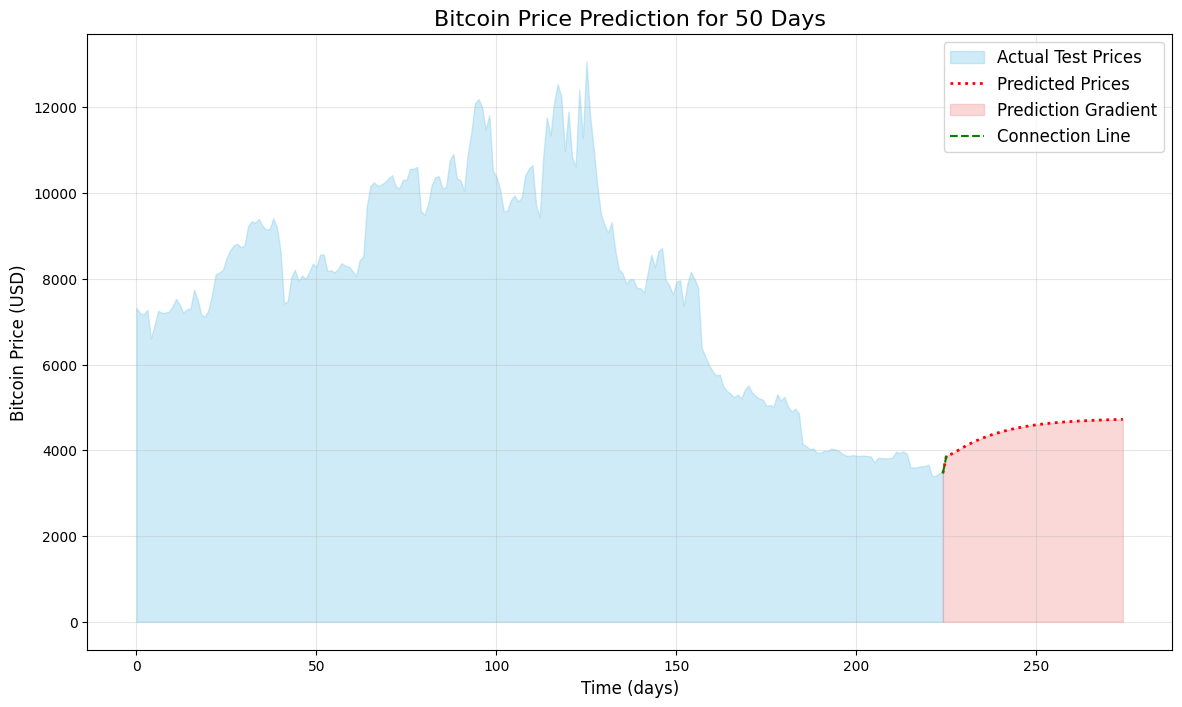

Saving predictions to ../dataset/prediction/bitcoin_price_predictions.csv...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━

c:\Users\kansa\OneDrive\Desktop\Stockie\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.1874 - val_loss: 0.0196
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0104 - val_loss: 0.0132
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0082 - val_loss: 0.0070
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0067 - val_loss: 0.0036
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0061 - val_loss: 0.0016
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0056 - val_loss: 4.6435e-04
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0046 - val_loss: 5.2252e-05
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0050 - val_loss: 2.1331e-05
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0042 - val_loss: 2.8129e-05
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0042 - val_loss: 8.0429e-05
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0045 - val_loss: 4.8747e-05
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/ste

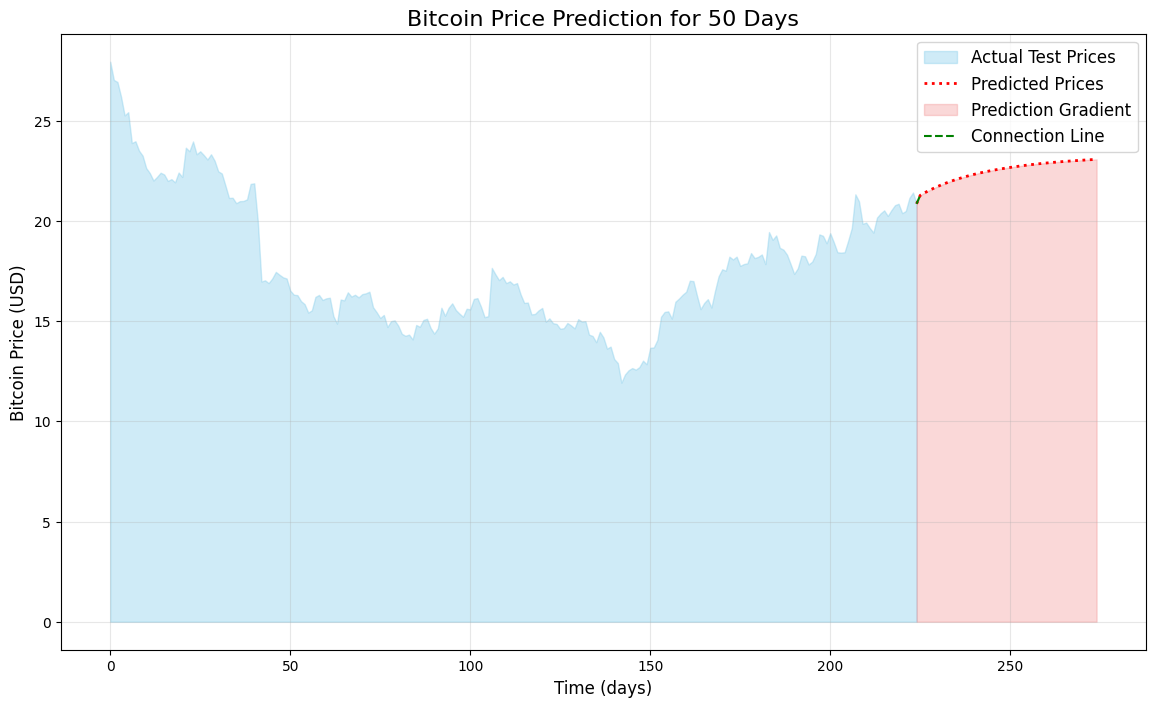

Saving predictions to ../dataset/prediction/tesla_price_predictions.csv...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━

c:\Users\kansa\OneDrive\Desktop\Stockie\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.1626 - val_loss: 0.0178
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0099 - val_loss: 0.0105
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0083 - val_loss: 0.0074
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0076 - val_loss: 0.0045
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0062 - val_loss: 0.0026
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0061 - val_loss: 0.0018
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0049 - val_loss: 0.0011
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0049 - val_loss: 6.4012e-04
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0044 - val_loss: 2.1150e-04
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0046 - val_loss: 1.1085e-04
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0041 - val_loss: 9.5470e-05
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss

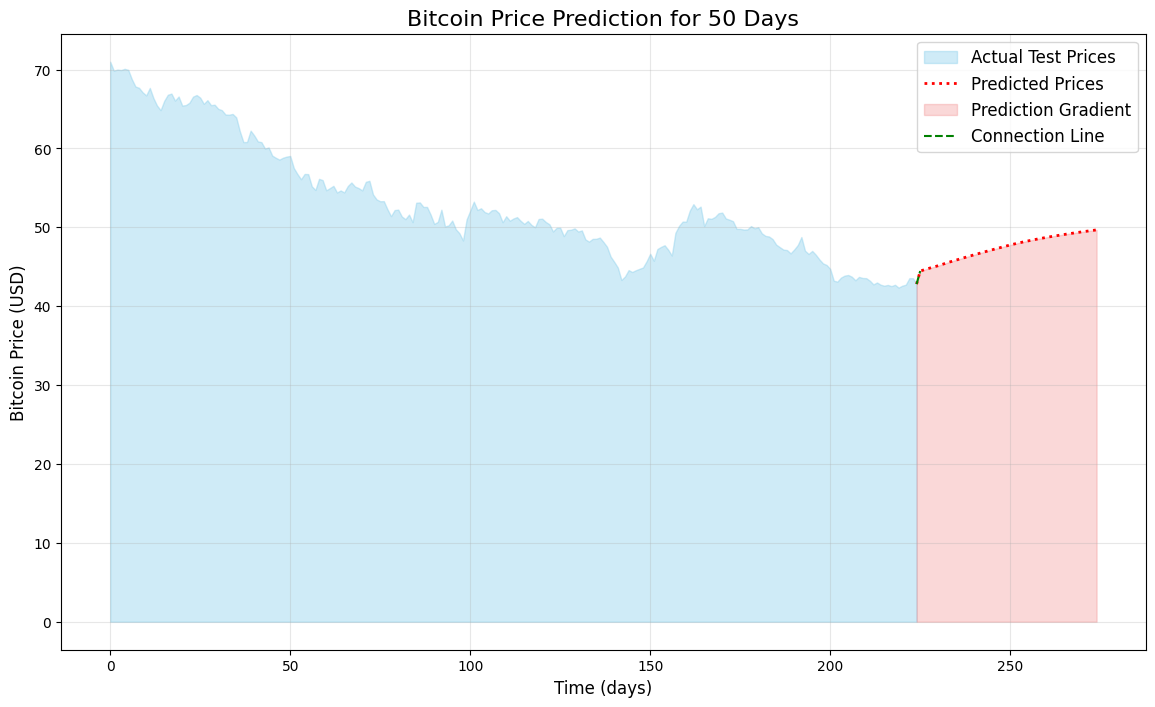

Saving predictions to ../dataset/prediction/apple_price_predictions.csv...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━

c:\Users\kansa\OneDrive\Desktop\Stockie\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.2428 - val_loss: 0.0181
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0102 - val_loss: 0.0125
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0084 - val_loss: 0.0074
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0067 - val_loss: 0.0038
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0060 - val_loss: 0.0021
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0055 - val_loss: 6.9394e-04
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0047 - val_loss: 4.1554e-04
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0046 - val_loss: 2.3529e-04
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0043 - val_loss: 1.6927e-04
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0042 - val_loss: 1.8119e-04
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0044 - val_loss: 1.5593e-04
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/ste

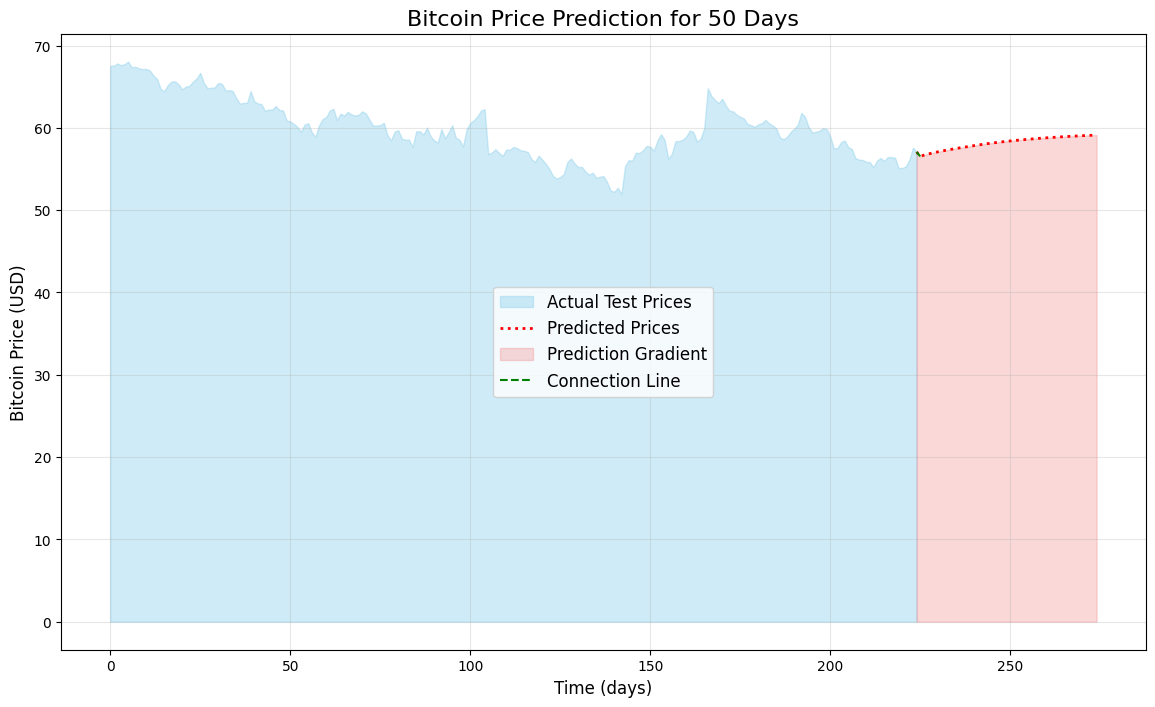

Saving predictions to ../dataset/prediction/google_price_predictions.csv...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

c:\Users\kansa\OneDrive\Desktop\Stockie\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.1113 - val_loss: 0.0129
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0061 - val_loss: 0.0077
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0047 - val_loss: 0.0051
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0033 - val_loss: 9.4747e-04
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0033 - val_loss: 2.7806e-04
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0030 - val_loss: 2.4231e-04
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0026 - val_loss: 1.1413e-04
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0026 - val_loss: 8.3903e-05
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0024 - val_loss: 1.0282e-04
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/ste

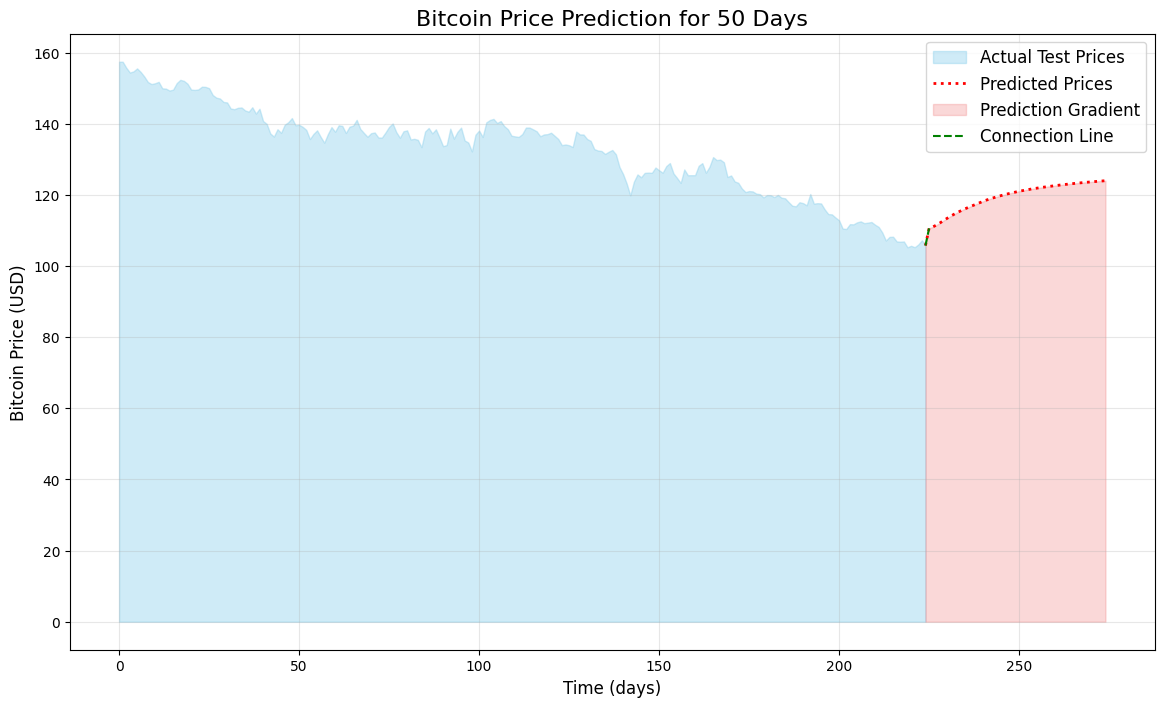

Saving predictions to ../dataset/prediction/microsoft_price_predictions.csv...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━

c:\Users\kansa\OneDrive\Desktop\Stockie\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.1079 - val_loss: 0.0174
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0046 - val_loss: 5.7227e-04
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0045 - val_loss: 4.6053e-05
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0035 - val_loss: 7.2196e-05
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0043 - val_loss: 1.3776e-05
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0031 - val_loss: 1.3184e-05
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0033 - val_loss: 3.7710e-05
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0031 - val_loss: 1.6502e-05
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0028 - val_loss: 2.3439e-05
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0038 - val_loss: 2.1098e-05
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step

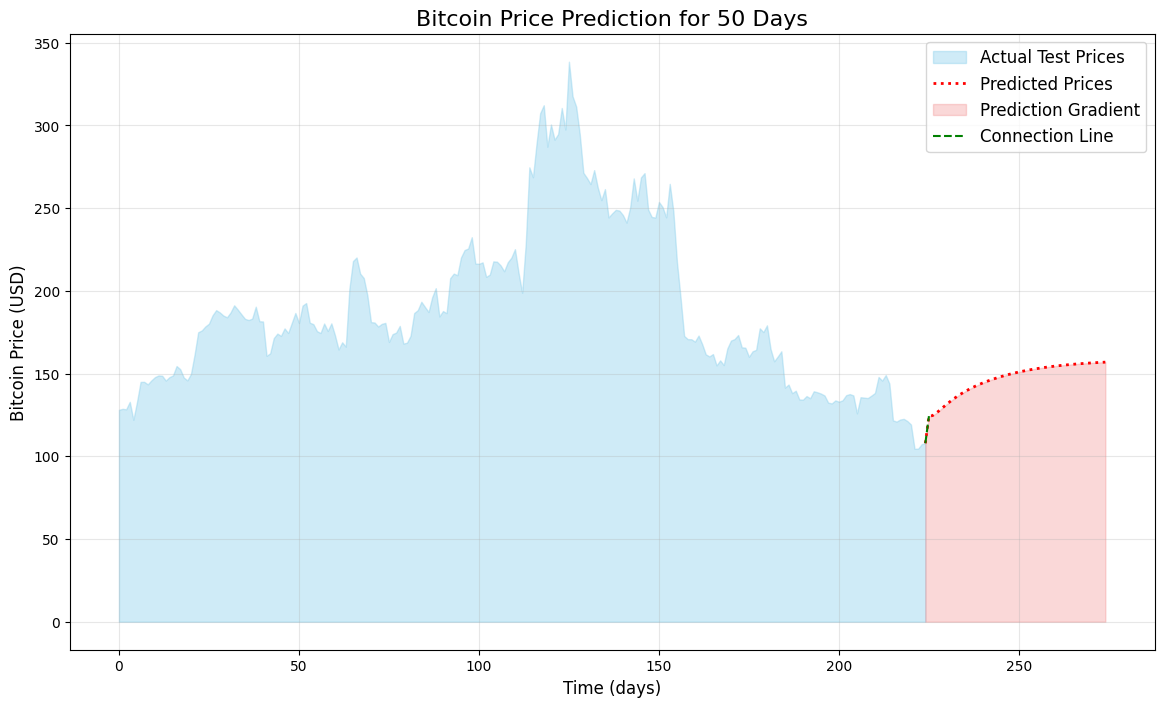

Saving predictions to ../dataset/prediction/ethereum_price_predictions.csv...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━

c:\Users\kansa\OneDrive\Desktop\Stockie\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 0.0446 - val_loss: 0.0145
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0046 - val_loss: 0.0052
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0026 - val_loss: 8.7273e-04
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0013 - val_loss: 1.6704e-04
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0012 - val_loss: 8.0527e-06
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0012 - val_loss: 5.5237e-05
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0012 - val_loss: 6.3182e-05
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0011 - val_loss: 8.2742e-06
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 9.8229e-04 - val_loss: 6.6461e-06
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0011 - val_loss: 3.5432e-05
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0011 - val_loss: 2.3318e-05
Epoch 12/50
57/57 ━━━━━━━━━━━━━━

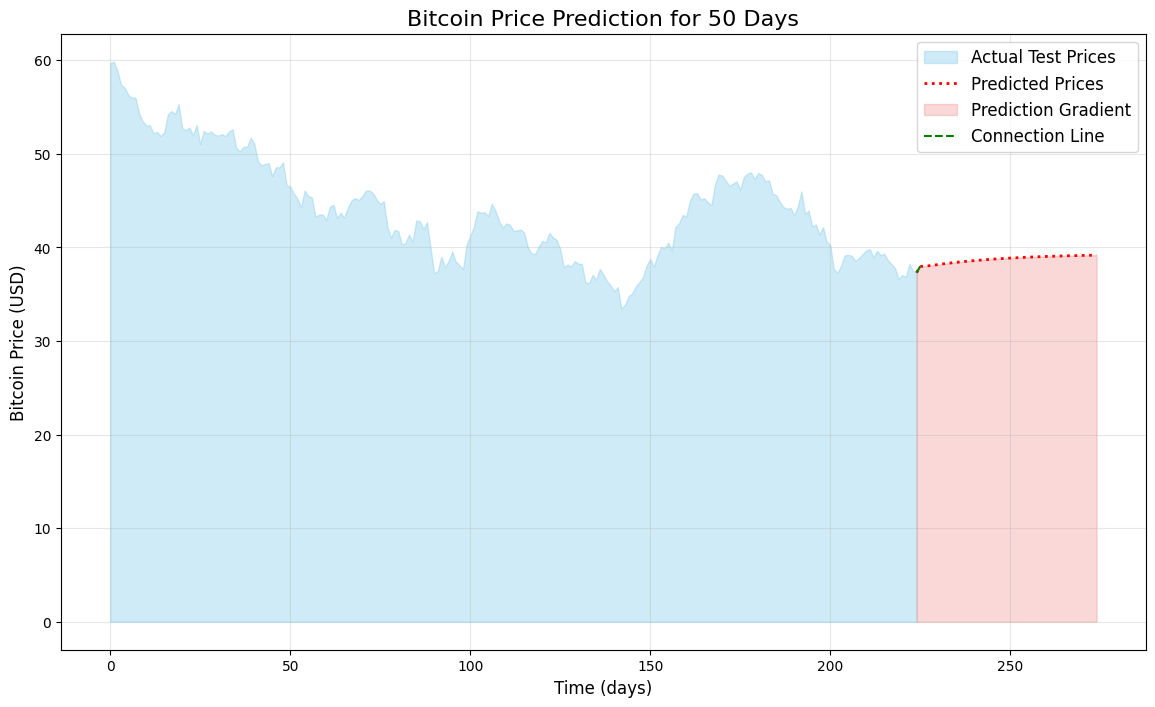

Saving predictions to ../dataset/prediction/nvidia_price_predictions.csv...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━

c:\Users\kansa\OneDrive\Desktop\Stockie\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - loss: 0.1236 - val_loss: 0.0049
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0076 - val_loss: 0.0020
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0050 - val_loss: 7.9059e-04
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0039 - val_loss: 3.6281e-04
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0031 - val_loss: 2.4424e-04
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0034 - val_loss: 2.4418e-04
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0028 - val_loss: 2.0388e-04
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0026 - val_loss: 4.0294e-04
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0027 - val_loss: 2.5029e-04
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0025 - val_loss: 3.6088e-04
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0022 - val_loss: 3.5490e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/ste

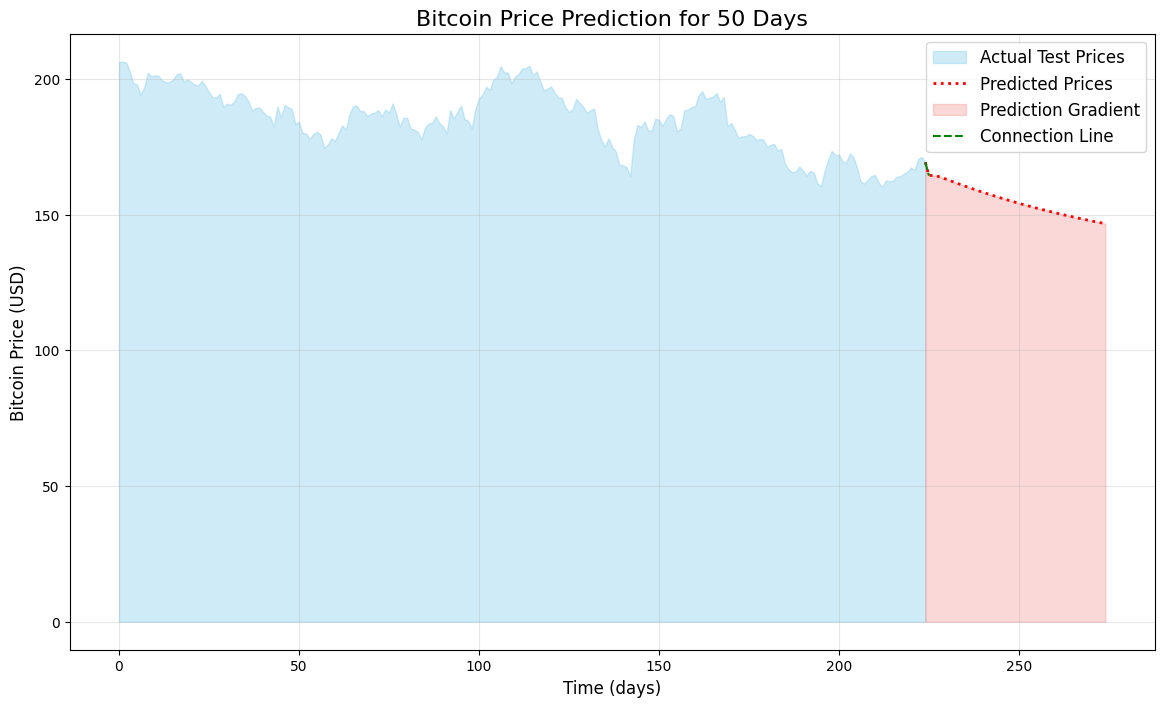

Saving predictions to ../dataset/prediction/meta_price_predictions.csv...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━

c:\Users\kansa\OneDrive\Desktop\Stockie\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.2064 - val_loss: 0.0207
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0129 - val_loss: 0.0100
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0112 - val_loss: 0.0056
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0091 - val_loss: 0.0019
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0073 - val_loss: 9.6249e-04
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0072 - val_loss: 4.7756e-04
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0058 - val_loss: 4.0923e-04
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0066 - val_loss: 3.4056e-04
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0065 - val_loss: 3.2172e-04
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0051 - val_loss: 3.5791e-04
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0060 - val_loss: 3.4110e-04
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90m

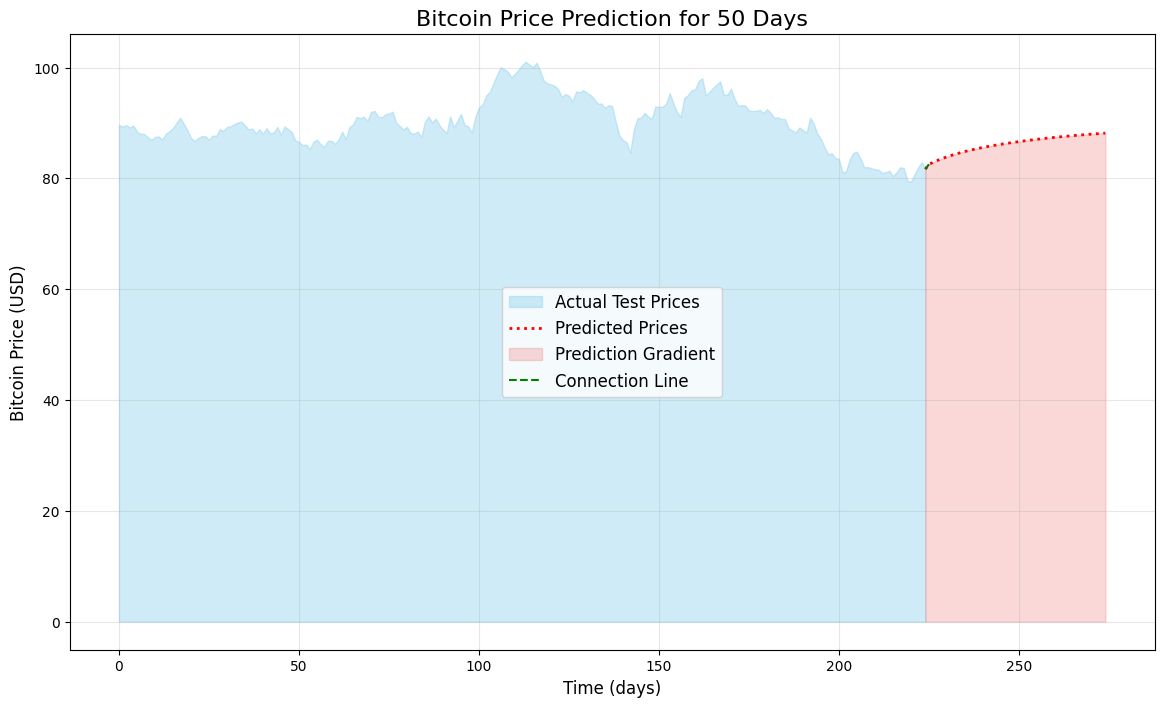

Saving predictions to ../dataset/prediction/amazon_price_predictions.csv...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━

c:\Users\kansa\OneDrive\Desktop\Stockie\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - loss: 0.3094 - val_loss: 0.0160
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0121 - val_loss: 0.0149
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0106 - val_loss: 0.0137
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0087 - val_loss: 0.0122
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0087 - val_loss: 0.0107
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0072 - val_loss: 0.0106
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0081 - val_loss: 0.0083
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0066 - val_loss: 0.0080
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0061 - val_loss: 0.0047
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0058 - val_loss: 0.0045
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0061 - val_l

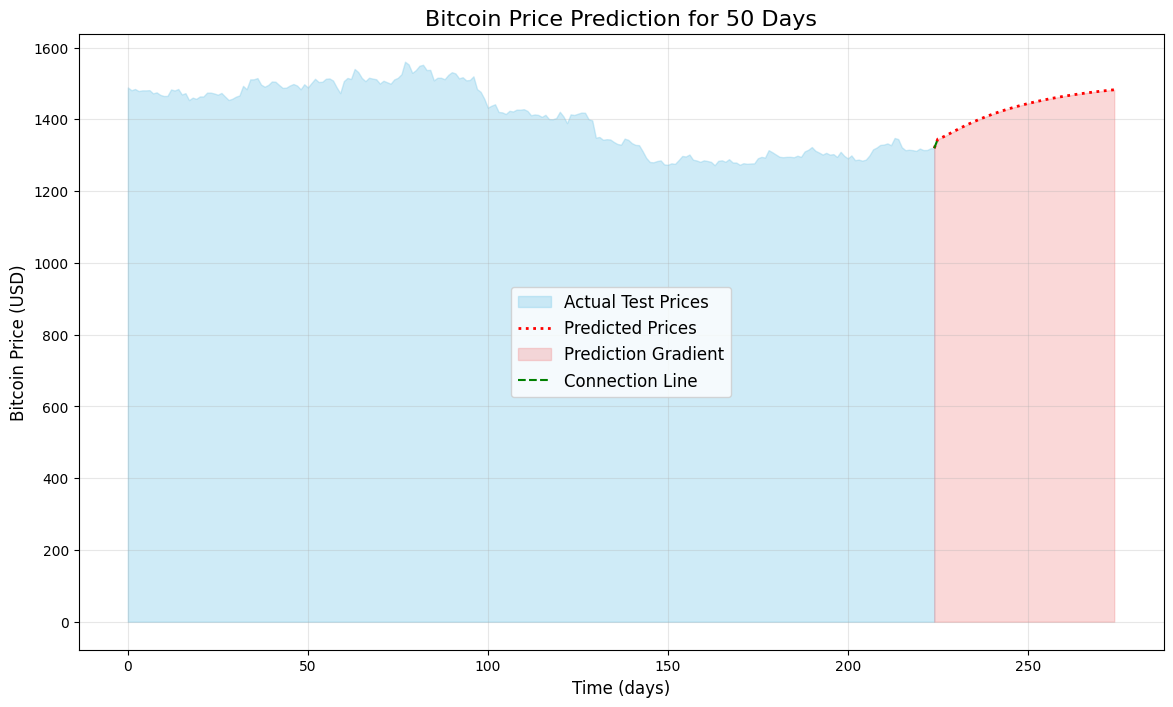

Saving predictions to ../dataset/prediction/gold_price_predictions.csv...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━

In [24]:
# List of stocks to predict
pred_stock = [
    "Bitcoin_Price",
    "Tesla_Price",
    "Apple_Price",
    "Google_Price",
    "Microsoft_Price",
    "Ethereum_Price",
    "Nvidia_Price",
    "Meta_Price",
    "Amazon_Price",
    "Gold_Price"
]

# Number of future days to predict
n_days = 50

# Loop through each stock
for stock in pred_stock:
    stock_df = pd.read_csv("../dataset/Stock_Market_Preprocessed_Dataset.csv")
    
    print(f"\nProcessing stock: {stock}")
    
    # Step 1: Prepare the data
    print("Preparing data...")
    scaler, X_train, X_test, y_train, y_test = prepare_data(
        stock_df=stock_df,
        target_column=stock,
        sequence_length=120,
        train_split=0.8
    )

    # Step 2: Train the model
    print("Training model...")
    model, mse, mae = train_and_evaluate_model(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        scaler=scaler,
        sequence_length=120,
        batch_size=16,
        epochs=50,
        stock_name=stock
    )

    print(f"Model trained for {stock} | MSE: {mse:.2f}, MAE: {mae:.2f}")

    # Step 3: Predict and visualize
    print(f"Predicting and visualizing for {n_days} days...")
    predict_and_visualize(n_days, model, scaler, X_test, y_test, sequence_length=120)

    # Step 4: Save predictions to CSV
    output_file = f"../dataset/prediction/{stock.lower()}_predictions.csv"
    print(f"Saving predictions to {output_file}...")
    save_predictions_to_csv(
        stock_name=stock,
        n_days=n_days,
        model=model,
        scaler=scaler,
        X_test=X_test,
        y_test=y_test,
        sequence_length=120,
        output_file=output_file
    )
    print(f"Completed processing for {stock}\n")
